# Tennis
Udacity Deep Reinforcement Learning Nanodegree Project 3

# Algorithms - How I train this agent?
## Experience Replay with Replay Buffer
Experience Replay is that save the experience(states, actions, rewards and next states in episodes) to Replay buffer. Therefore get a random samples to learn from saved experience. So we can learn the agent from much more experiences.

## Actor&Critic Network
Actor and Critic network is simple fully-connected network.
#### Actor
- layer 1: input: state_size(24), output: 128, relu activation
- layer 2: input: 128, output: 128, relu activation
- layer 3: input: 128, output: action_size(2)

#### Critic
- layer 1: input: num_agents * state_size * action_size (2 * 24 * 2 = 96), output: 128, relu activation
- layer 2: input: 128, output: 128, relu activation
- layer 3: input: 128, output: value(1)


## Ornstein-Uhlenbeck Noise
add a noise for the action. In before processes, we use epsilon-greedy to explore the environment. But this method cannot be applied to policy based methods. Instead we choose that add a noise to the action.

## DDPG
DDPG(Deep Deterministic Policy Gradients) is model-free, off-policy actor-critic algorithm, based on Deep Deterministic Policy(DPG). DDPG uses below methods

- replay buffer for online batch update
- soft target-update every N steps
- batch normalization for feature scaling
- noise process for the exploration
### Actor-Critic Method
actor-critic method use both policy-based(actor), value-based(critic) together. In stochastic action space, Actor predicts the best action from state, Critic estimates value of actor's determination. Actor is trained to maximize the probability of action that has highest estimated value from critic. Critic is trained to correctly estimate the reward from environment.

### Actor-Critic in DDPG
But in continous action space. Actor is deterministic that means actor returns just action(not probability). So we need to choose another actor tranining method. In DDPG, we maximize the critic's expected reward of Actor's deterministic action using Gradient Ascent. See below codes in learn() method
```
actions_pred = self.actor_local(states)
actor_loss = -self.critic_local(states, actions_pred).mean()
```
### DDPG Algorithm pseudo code¶
<img src="img/ddpg.png" />

## MADDPG(Multi-Agent DDPG)
In MADDPG, Actor(policy-based model) determines action from states like DDPG. But critic(value-based model) estimates the value from states and action of <b>multple agent</b>. In tennis environment, each agent's state is their own observation. But critic uses all agent's observation - that is called <i>centeralized action value</i>.<br>
<img src="img/maddpg.png" />

before you run this notebook, please read [README.md](README.md) and install the required packages.<br>

In [8]:
import time
from collections import deque

from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
import torch
import logging
import pandas as pd
from maddpg import MADDPGAgents

In [9]:
# logging to file
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[
        logging.FileHandler("debug.log"),
        logging.StreamHandler()
    ]
)

## Load the Unity Environements

In [6]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
Device: cuda:0


## Hyperparameters

- random actions until 1000 episodes
- update 2 times every 4 steps
- replay buffer size: 10000, Prevent to sample old policy trajectories.
- batch size: 512
- noise decay: As the learning progresses, decrease the action noise for exploitation. when noise decay is 0.999, after 3000 episodes noise weight is 0.04. So noise almost disappears
- tau: soft-target update
- gamma: Next Q Target constant
- learning rates, no weight decay

In [7]:
params = {
    'action_size': action_size,
    'state_size': state_size,
    'num_agents': num_agents,

    'buffer_size': 10000,
    'batch_size': 512,

    'noise_decay': 0.999,
    'tau': 0.001,
    'gamma': 0.99,

    'actor_lr': 0.001,
    'actor_weight_decay': 0.0,
    'critic_lr': 0.001,
    'critic_weight_decay': 0.0
}

agents = MADDPGAgents(random_seed=7, device=device, params=params)

In [5]:
def run_episode(env, brain_name, agents, n_episodes=5000, max_steps=1000, random_episodes=1000, update_every=4, update_count=2, scores=[]):
    score_total_means = deque(maxlen=100)
    
    for i_episode in range(1, n_episodes+1):
        # Reset Env and Agent
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        
        # total score of 20 agents
        total_rewards = np.zeros(2)
        
        agents.reset()
        
        start_time = time.time()
        
        for t in range(max_steps):
            if i_episode < random_episodes:
                actions = agents.act_random()
            else:
                actions = agents.act(states)
            env_info = env.step(actions)[brain_name]
            
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done 

            agents.step(states, actions, rewards, next_states, dones)
            
            states = next_states
            total_rewards += env_info.rewards
            
            if t % update_every == 0:
                for _ in range(update_count):
                    agents.start_learn()

            if np.any(dones):
                break

    
        duration = time.time() - start_time
        
        min_score = np.min(total_rewards)
        max_score = np.max(total_rewards)
        scores.append(max_score)
        score_total_means.append(max_score)
        total_average = np.mean(score_total_means)
        
        logging.info('\rEpisode {}({} steps)\tTotal Average Score: {:.2f}\tMin: {:.2f}\tMax: {:.2f}\tDuration: {:.2f}'
              .format(i_episode, t, total_average, min_score, max_score, duration))

        if i_episode % 10 == 0:
            agents.save()
            
        if total_average >= 0.5 and i_episode >= 100:
            logging.info('Problem Solved after {} epsisodes!! Total Average score: {:.2f}'.format(i_episode, total_average))
            agents.save("solved")
            break

In [8]:
scores = []

In [9]:
run_episode(env, brain_name, agents, scores=scores)

Episode 1(30 steps)	Total Average Score: 0.09	Min: 0.00	Max: 0.09	Duration: 0.22
Episode 2(50 steps)	Total Average Score: 0.10	Min: 0.09	Max: 0.10	Duration: 0.11
Episode 3(13 steps)	Total Average Score: 0.06	Min: -0.01	Max: 0.00	Duration: 0.03
Episode 4(25 steps)	Total Average Score: 0.05	Min: -0.01	Max: 0.00	Duration: 0.05
Episode 5(13 steps)	Total Average Score: 0.04	Min: -0.01	Max: 0.00	Duration: 0.03
Episode 6(14 steps)	Total Average Score: 0.03	Min: -0.01	Max: 0.00	Duration: 0.03
Episode 7(13 steps)	Total Average Score: 0.03	Min: -0.01	Max: 0.00	Duration: 0.04
Episode 8(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.03
Episode 9(14 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.03
Episode 10(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.03
Episode 11(14 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.03
Episode 12(29 steps)	Total Average Score: 0.02	Min: 0.00	Max: 0.09	Duration: 0.07
Episode 13(13 st

Episode 98(23 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.75
Episode 99(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.48
Episode 100(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.43
Episode 101(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.59
Episode 102(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.74
Episode 103(31 steps)	Total Average Score: 0.02	Min: 0.00	Max: 0.09	Duration: 1.01
Episode 104(14 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.48
Episode 105(30 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.10	Duration: 1.10
Episode 106(32 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 1.10
Episode 107(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.73
Episode 108(31 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 1.09
Episode 109(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 

Episode 196(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.48
Episode 197(20 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.81
Episode 198(50 steps)	Total Average Score: 0.02	Min: 0.09	Max: 0.10	Duration: 1.84
Episode 199(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.45
Episode 200(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.45
Episode 201(29 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.89
Episode 202(29 steps)	Total Average Score: 0.02	Min: 0.00	Max: 0.09	Duration: 0.92
Episode 203(31 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.10	Duration: 0.97
Episode 204(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.52
Episode 205(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.47
Episode 206(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.47
Episode 207(16 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration:

Episode 294(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.46
Episode 295(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.45
Episode 296(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.45
Episode 297(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.46
Episode 298(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.45
Episode 299(14 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.47
Episode 300(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.48
Episode 301(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.47
Episode 302(37 steps)	Total Average Score: 0.02	Min: 0.09	Max: 0.10	Duration: 1.37
Episode 303(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.72
Episode 304(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.51
Episode 305(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration

Episode 392(31 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.10	Duration: 0.94
Episode 393(15 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.48
Episode 394(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.77
Episode 395(35 steps)	Total Average Score: 0.03	Min: -0.01	Max: 0.10	Duration: 1.23
Episode 396(14 steps)	Total Average Score: 0.03	Min: -0.01	Max: 0.00	Duration: 0.50
Episode 397(13 steps)	Total Average Score: 0.03	Min: -0.01	Max: 0.00	Duration: 0.48
Episode 398(13 steps)	Total Average Score: 0.03	Min: -0.01	Max: 0.00	Duration: 0.48
Episode 399(13 steps)	Total Average Score: 0.03	Min: -0.01	Max: 0.00	Duration: 0.60
Episode 400(14 steps)	Total Average Score: 0.03	Min: -0.01	Max: 0.00	Duration: 0.49
Episode 401(13 steps)	Total Average Score: 0.03	Min: -0.01	Max: 0.00	Duration: 0.47
Episode 402(30 steps)	Total Average Score: 0.03	Min: -0.01	Max: 0.10	Duration: 0.93
Episode 403(16 steps)	Total Average Score: 0.03	Min: -0.01	Max: 0.00	Duratio

Episode 490(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.50
Episode 491(14 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.45
Episode 492(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.49
Episode 493(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.63
Episode 494(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.56
Episode 495(30 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.10	Duration: 1.00
Episode 496(30 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.10	Duration: 1.13
Episode 497(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.53
Episode 498(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.58
Episode 499(50 steps)	Total Average Score: 0.02	Min: 0.09	Max: 0.10	Duration: 1.62
Episode 500(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.48
Episode 501(23 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.10	Duration

Episode 588(29 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.10	Duration: 0.95
Episode 589(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.47
Episode 590(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.48
Episode 591(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.48
Episode 592(14 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.48
Episode 593(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.46
Episode 594(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.54
Episode 595(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.48
Episode 596(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.49
Episode 597(31 steps)	Total Average Score: 0.02	Min: 0.00	Max: 0.09	Duration: 0.95
Episode 598(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.45
Episode 599(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration

Episode 686(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.56
Episode 687(29 steps)	Total Average Score: 0.02	Min: 0.00	Max: 0.09	Duration: 1.13
Episode 688(14 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.62
Episode 689(71 steps)	Total Average Score: 0.02	Min: 0.09	Max: 0.20	Duration: 2.47
Episode 690(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.55
Episode 691(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.55
Episode 692(31 steps)	Total Average Score: 0.02	Min: 0.00	Max: 0.09	Duration: 1.10
Episode 693(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.54
Episode 694(52 steps)	Total Average Score: 0.02	Min: 0.09	Max: 0.10	Duration: 1.87
Episode 695(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.53
Episode 696(30 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.10	Duration: 1.11
Episode 697(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0

Episode 784(14 steps)	Total Average Score: 0.01	Min: -0.01	Max: 0.00	Duration: 0.56
Episode 785(13 steps)	Total Average Score: 0.01	Min: -0.01	Max: 0.00	Duration: 0.53
Episode 786(13 steps)	Total Average Score: 0.01	Min: -0.01	Max: 0.00	Duration: 0.54
Episode 787(13 steps)	Total Average Score: 0.01	Min: -0.01	Max: 0.00	Duration: 0.53
Episode 788(13 steps)	Total Average Score: 0.01	Min: -0.01	Max: 0.00	Duration: 0.57
Episode 789(13 steps)	Total Average Score: 0.01	Min: -0.01	Max: 0.00	Duration: 0.55
Episode 790(15 steps)	Total Average Score: 0.01	Min: -0.01	Max: 0.00	Duration: 0.56
Episode 791(22 steps)	Total Average Score: 0.01	Min: -0.01	Max: 0.10	Duration: 0.86
Episode 792(13 steps)	Total Average Score: 0.01	Min: -0.01	Max: 0.00	Duration: 0.55
Episode 793(13 steps)	Total Average Score: 0.01	Min: -0.01	Max: 0.00	Duration: 0.53
Episode 794(29 steps)	Total Average Score: 0.01	Min: 0.00	Max: 0.09	Duration: 1.12
Episode 795(13 steps)	Total Average Score: 0.01	Min: -0.01	Max: 0.00	Duration

Episode 882(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.76
Episode 883(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.63
Episode 884(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.65
Episode 885(29 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.10	Duration: 1.28
Episode 886(15 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.75
Episode 887(14 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.70
Episode 888(14 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.71
Episode 889(14 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.75
Episode 890(25 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 1.11
Episode 891(12 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.63
Episode 892(14 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.63
Episode 893(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duratio

Episode 980(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.56
Episode 981(14 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.49
Episode 982(22 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.10	Duration: 0.75
Episode 983(31 steps)	Total Average Score: 0.02	Min: 0.00	Max: 0.09	Duration: 1.34
Episode 984(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.72
Episode 985(14 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.65
Episode 986(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.75
Episode 987(15 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.70
Episode 988(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.72
Episode 989(13 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration: 0.71
Episode 990(28 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.10	Duration: 1.15
Episode 991(14 steps)	Total Average Score: 0.02	Min: -0.01	Max: 0.00	Duration

Episode 1077(13 steps)	Total Average Score: 0.01	Min: -0.01	Max: 0.00	Duration: 0.53
Episode 1078(13 steps)	Total Average Score: 0.01	Min: -0.01	Max: 0.00	Duration: 0.51
Episode 1079(14 steps)	Total Average Score: 0.01	Min: -0.01	Max: 0.00	Duration: 0.55
Episode 1080(13 steps)	Total Average Score: 0.01	Min: -0.01	Max: 0.00	Duration: 0.54
Episode 1081(13 steps)	Total Average Score: 0.01	Min: -0.01	Max: 0.00	Duration: 0.52
Episode 1082(13 steps)	Total Average Score: 0.01	Min: -0.01	Max: 0.00	Duration: 0.52
Episode 1083(13 steps)	Total Average Score: 0.01	Min: -0.01	Max: 0.00	Duration: 0.52
Episode 1084(14 steps)	Total Average Score: 0.01	Min: -0.01	Max: 0.00	Duration: 0.52
Episode 1085(13 steps)	Total Average Score: 0.01	Min: -0.01	Max: 0.00	Duration: 0.57
Episode 1086(13 steps)	Total Average Score: 0.01	Min: -0.01	Max: 0.00	Duration: 0.52
Episode 1087(13 steps)	Total Average Score: 0.01	Min: -0.01	Max: 0.00	Duration: 0.52
Episode 1088(13 steps)	Total Average Score: 0.01	Min: -0.01	Max: 

Episode 1174(14 steps)	Total Average Score: 0.00	Min: -0.01	Max: 0.00	Duration: 0.50
Episode 1175(13 steps)	Total Average Score: 0.00	Min: -0.01	Max: 0.00	Duration: 0.49
Episode 1176(13 steps)	Total Average Score: 0.00	Min: -0.01	Max: 0.00	Duration: 0.51
Episode 1177(13 steps)	Total Average Score: 0.00	Min: -0.01	Max: 0.00	Duration: 0.52
Episode 1178(13 steps)	Total Average Score: 0.00	Min: -0.01	Max: 0.00	Duration: 0.48
Episode 1179(14 steps)	Total Average Score: 0.00	Min: -0.01	Max: 0.00	Duration: 0.49
Episode 1180(13 steps)	Total Average Score: 0.00	Min: -0.01	Max: 0.00	Duration: 0.53
Episode 1181(13 steps)	Total Average Score: 0.00	Min: -0.01	Max: 0.00	Duration: 0.48
Episode 1182(13 steps)	Total Average Score: 0.00	Min: -0.01	Max: 0.00	Duration: 0.49
Episode 1183(13 steps)	Total Average Score: 0.00	Min: -0.01	Max: 0.00	Duration: 0.49
Episode 1184(14 steps)	Total Average Score: 0.00	Min: -0.01	Max: 0.00	Duration: 0.49
Episode 1185(13 steps)	Total Average Score: 0.00	Min: -0.01	Max: 

Episode 1271(13 steps)	Total Average Score: 0.00	Min: -0.01	Max: 0.00	Duration: 0.55
Episode 1272(13 steps)	Total Average Score: 0.00	Min: -0.01	Max: 0.00	Duration: 0.49
Episode 1273(13 steps)	Total Average Score: 0.00	Min: -0.01	Max: 0.00	Duration: 0.51
Episode 1274(14 steps)	Total Average Score: 0.00	Min: -0.01	Max: 0.00	Duration: 0.54
Episode 1275(13 steps)	Total Average Score: 0.00	Min: -0.01	Max: 0.00	Duration: 0.52
Episode 1276(13 steps)	Total Average Score: 0.00	Min: -0.01	Max: 0.00	Duration: 0.50
Episode 1277(13 steps)	Total Average Score: 0.00	Min: -0.01	Max: 0.00	Duration: 0.77
Episode 1278(13 steps)	Total Average Score: 0.00	Min: -0.01	Max: 0.00	Duration: 0.51
Episode 1279(14 steps)	Total Average Score: 0.00	Min: -0.01	Max: 0.00	Duration: 0.54
Episode 1280(13 steps)	Total Average Score: 0.00	Min: -0.01	Max: 0.00	Duration: 0.48
Episode 1281(13 steps)	Total Average Score: 0.00	Min: -0.01	Max: 0.00	Duration: 0.49
Episode 1282(13 steps)	Total Average Score: 0.00	Min: -0.01	Max: 

Episode 1368(13 steps)	Total Average Score: 0.01	Min: -0.01	Max: 0.00	Duration: 0.50
Episode 1369(13 steps)	Total Average Score: 0.01	Min: -0.01	Max: 0.00	Duration: 0.51
Episode 1370(13 steps)	Total Average Score: 0.01	Min: -0.01	Max: 0.00	Duration: 0.56
Episode 1371(14 steps)	Total Average Score: 0.01	Min: -0.01	Max: 0.00	Duration: 0.52
Episode 1372(14 steps)	Total Average Score: 0.01	Min: -0.01	Max: 0.00	Duration: 0.49
Episode 1373(13 steps)	Total Average Score: 0.01	Min: -0.01	Max: 0.00	Duration: 0.70
Episode 1374(13 steps)	Total Average Score: 0.01	Min: -0.01	Max: 0.00	Duration: 0.52
Episode 1375(14 steps)	Total Average Score: 0.01	Min: -0.01	Max: 0.00	Duration: 0.49
Episode 1376(13 steps)	Total Average Score: 0.01	Min: -0.01	Max: 0.00	Duration: 0.49
Episode 1377(13 steps)	Total Average Score: 0.01	Min: -0.01	Max: 0.00	Duration: 0.48
Episode 1378(14 steps)	Total Average Score: 0.01	Min: -0.01	Max: 0.00	Duration: 0.50
Episode 1379(30 steps)	Total Average Score: 0.01	Min: -0.01	Max: 

Episode 1465(31 steps)	Total Average Score: 0.03	Min: 0.00	Max: 0.09	Duration: 1.06
Episode 1466(32 steps)	Total Average Score: 0.03	Min: -0.01	Max: 0.10	Duration: 1.13
Episode 1467(31 steps)	Total Average Score: 0.03	Min: 0.00	Max: 0.09	Duration: 0.98
Episode 1468(28 steps)	Total Average Score: 0.03	Min: 0.00	Max: 0.09	Duration: 0.99
Episode 1469(14 steps)	Total Average Score: 0.03	Min: -0.01	Max: 0.00	Duration: 0.56
Episode 1470(32 steps)	Total Average Score: 0.03	Min: -0.01	Max: 0.10	Duration: 1.12
Episode 1471(13 steps)	Total Average Score: 0.03	Min: -0.01	Max: 0.00	Duration: 0.48
Episode 1472(29 steps)	Total Average Score: 0.03	Min: 0.00	Max: 0.09	Duration: 1.00
Episode 1473(14 steps)	Total Average Score: 0.03	Min: -0.01	Max: 0.00	Duration: 0.51
Episode 1474(32 steps)	Total Average Score: 0.03	Min: -0.02	Max: 0.10	Duration: 1.10
Episode 1475(13 steps)	Total Average Score: 0.03	Min: -0.01	Max: 0.00	Duration: 0.48
Episode 1476(13 steps)	Total Average Score: 0.03	Min: -0.01	Max: 0.00

Episode 1562(31 steps)	Total Average Score: 0.07	Min: 0.00	Max: 0.09	Duration: 1.01
Episode 1563(30 steps)	Total Average Score: 0.07	Min: 0.00	Max: 0.09	Duration: 1.02
Episode 1564(29 steps)	Total Average Score: 0.08	Min: 0.00	Max: 0.09	Duration: 0.98
Episode 1565(30 steps)	Total Average Score: 0.08	Min: 0.00	Max: 0.09	Duration: 0.98
Episode 1566(13 steps)	Total Average Score: 0.07	Min: -0.01	Max: 0.00	Duration: 0.50
Episode 1567(30 steps)	Total Average Score: 0.07	Min: 0.00	Max: 0.09	Duration: 0.99
Episode 1568(29 steps)	Total Average Score: 0.07	Min: 0.00	Max: 0.09	Duration: 1.00
Episode 1569(14 steps)	Total Average Score: 0.07	Min: -0.01	Max: 0.00	Duration: 0.49
Episode 1570(29 steps)	Total Average Score: 0.07	Min: 0.00	Max: 0.09	Duration: 1.11
Episode 1571(13 steps)	Total Average Score: 0.07	Min: -0.01	Max: 0.00	Duration: 0.53
Episode 1572(31 steps)	Total Average Score: 0.07	Min: -0.01	Max: 0.10	Duration: 1.05
Episode 1573(14 steps)	Total Average Score: 0.07	Min: -0.01	Max: 0.00	Du

Episode 1659(30 steps)	Total Average Score: 0.08	Min: -0.01	Max: 0.10	Duration: 1.08
Episode 1660(15 steps)	Total Average Score: 0.08	Min: -0.01	Max: 0.00	Duration: 0.55
Episode 1661(15 steps)	Total Average Score: 0.08	Min: -0.01	Max: 0.00	Duration: 0.57
Episode 1662(13 steps)	Total Average Score: 0.08	Min: -0.01	Max: 0.00	Duration: 0.54
Episode 1663(15 steps)	Total Average Score: 0.08	Min: -0.01	Max: 0.00	Duration: 0.73
Episode 1664(15 steps)	Total Average Score: 0.08	Min: -0.01	Max: 0.00	Duration: 0.74
Episode 1665(50 steps)	Total Average Score: 0.08	Min: 0.09	Max: 0.10	Duration: 2.09
Episode 1666(13 steps)	Total Average Score: 0.08	Min: -0.01	Max: 0.00	Duration: 0.56
Episode 1667(13 steps)	Total Average Score: 0.08	Min: -0.01	Max: 0.00	Duration: 0.58
Episode 1668(13 steps)	Total Average Score: 0.07	Min: -0.01	Max: 0.00	Duration: 0.57
Episode 1669(88 steps)	Total Average Score: 0.08	Min: 0.19	Max: 0.20	Duration: 3.55
Episode 1670(14 steps)	Total Average Score: 0.08	Min: -0.01	Max: 0.

Episode 1756(67 steps)	Total Average Score: 0.08	Min: 0.09	Max: 0.20	Duration: 2.31
Episode 1757(45 steps)	Total Average Score: 0.08	Min: -0.01	Max: 0.10	Duration: 1.58
Episode 1758(146 steps)	Total Average Score: 0.08	Min: 0.29	Max: 0.40	Duration: 5.16
Episode 1759(30 steps)	Total Average Score: 0.08	Min: 0.00	Max: 0.09	Duration: 1.39
Episode 1760(31 steps)	Total Average Score: 0.08	Min: -0.01	Max: 0.10	Duration: 1.24
Episode 1761(51 steps)	Total Average Score: 0.08	Min: 0.09	Max: 0.10	Duration: 1.78
Episode 1762(105 steps)	Total Average Score: 0.08	Min: 0.19	Max: 0.30	Duration: 3.49
Episode 1763(30 steps)	Total Average Score: 0.09	Min: -0.01	Max: 0.10	Duration: 1.04
Episode 1764(29 steps)	Total Average Score: 0.09	Min: -0.01	Max: 0.10	Duration: 1.06
Episode 1765(13 steps)	Total Average Score: 0.09	Min: -0.01	Max: 0.00	Duration: 0.51
Episode 1766(12 steps)	Total Average Score: 0.09	Min: -0.01	Max: 0.00	Duration: 0.52
Episode 1767(29 steps)	Total Average Score: 0.09	Min: 0.00	Max: 0.09

Episode 1853(29 steps)	Total Average Score: 0.17	Min: -0.01	Max: 0.10	Duration: 1.40
Episode 1854(30 steps)	Total Average Score: 0.17	Min: -0.01	Max: 0.10	Duration: 1.28
Episode 1855(29 steps)	Total Average Score: 0.16	Min: -0.01	Max: 0.10	Duration: 1.24
Episode 1856(28 steps)	Total Average Score: 0.16	Min: -0.01	Max: 0.10	Duration: 1.29
Episode 1857(67 steps)	Total Average Score: 0.16	Min: 0.09	Max: 0.20	Duration: 2.27
Episode 1858(51 steps)	Total Average Score: 0.16	Min: 0.09	Max: 0.10	Duration: 1.69
Episode 1859(51 steps)	Total Average Score: 0.16	Min: 0.09	Max: 0.10	Duration: 1.82
Episode 1860(51 steps)	Total Average Score: 0.16	Min: 0.09	Max: 0.10	Duration: 1.91
Episode 1861(29 steps)	Total Average Score: 0.16	Min: -0.01	Max: 0.10	Duration: 1.19
Episode 1862(67 steps)	Total Average Score: 0.16	Min: 0.09	Max: 0.20	Duration: 2.20
Episode 1863(29 steps)	Total Average Score: 0.16	Min: -0.01	Max: 0.10	Duration: 0.99
Episode 1864(66 steps)	Total Average Score: 0.16	Min: 0.09	Max: 0.20	D

Episode 1950(30 steps)	Total Average Score: 0.20	Min: -0.01	Max: 0.10	Duration: 0.97
Episode 1951(124 steps)	Total Average Score: 0.20	Min: 0.29	Max: 0.30	Duration: 3.90
Episode 1952(89 steps)	Total Average Score: 0.20	Min: 0.19	Max: 0.20	Duration: 2.80
Episode 1953(30 steps)	Total Average Score: 0.20	Min: -0.01	Max: 0.10	Duration: 0.98
Episode 1954(107 steps)	Total Average Score: 0.20	Min: 0.19	Max: 0.30	Duration: 3.30
Episode 1955(30 steps)	Total Average Score: 0.20	Min: -0.01	Max: 0.10	Duration: 0.97
Episode 1956(219 steps)	Total Average Score: 0.21	Min: 0.50	Max: 0.59	Duration: 6.75
Episode 1957(30 steps)	Total Average Score: 0.21	Min: -0.01	Max: 0.10	Duration: 0.99
Episode 1958(34 steps)	Total Average Score: 0.21	Min: 0.09	Max: 0.10	Duration: 1.10
Episode 1959(30 steps)	Total Average Score: 0.21	Min: -0.01	Max: 0.10	Duration: 0.97
Episode 1960(68 steps)	Total Average Score: 0.21	Min: 0.09	Max: 0.20	Duration: 2.20
Episode 1961(51 steps)	Total Average Score: 0.21	Min: 0.09	Max: 0.10

Episode 2047(150 steps)	Total Average Score: 0.23	Min: 0.29	Max: 0.40	Duration: 4.63
Episode 2048(360 steps)	Total Average Score: 0.24	Min: 0.89	Max: 0.90	Duration: 11.05
Episode 2049(29 steps)	Total Average Score: 0.23	Min: -0.01	Max: 0.10	Duration: 0.98
Episode 2050(29 steps)	Total Average Score: 0.23	Min: -0.01	Max: 0.10	Duration: 0.95
Episode 2051(29 steps)	Total Average Score: 0.23	Min: -0.01	Max: 0.10	Duration: 0.96
Episode 2052(69 steps)	Total Average Score: 0.23	Min: 0.09	Max: 0.20	Duration: 2.20
Episode 2053(35 steps)	Total Average Score: 0.23	Min: -0.01	Max: 0.00	Duration: 1.08
Episode 2054(31 steps)	Total Average Score: 0.23	Min: -0.01	Max: 0.10	Duration: 0.96
Episode 2055(28 steps)	Total Average Score: 0.23	Min: -0.01	Max: 0.10	Duration: 0.96
Episode 2056(30 steps)	Total Average Score: 0.22	Min: -0.01	Max: 0.10	Duration: 0.99
Episode 2057(29 steps)	Total Average Score: 0.22	Min: -0.01	Max: 0.10	Duration: 0.97
Episode 2058(29 steps)	Total Average Score: 0.22	Min: 0.00	Max: 0

Episode 2144(51 steps)	Total Average Score: 0.12	Min: 0.09	Max: 0.10	Duration: 1.60
Episode 2145(51 steps)	Total Average Score: 0.12	Min: 0.09	Max: 0.10	Duration: 1.54
Episode 2146(51 steps)	Total Average Score: 0.12	Min: 0.09	Max: 0.10	Duration: 1.63
Episode 2147(51 steps)	Total Average Score: 0.12	Min: 0.09	Max: 0.10	Duration: 1.59
Episode 2148(30 steps)	Total Average Score: 0.11	Min: -0.01	Max: 0.10	Duration: 0.97
Episode 2149(29 steps)	Total Average Score: 0.11	Min: -0.01	Max: 0.10	Duration: 0.97
Episode 2150(35 steps)	Total Average Score: 0.11	Min: -0.01	Max: 0.10	Duration: 1.09
Episode 2151(31 steps)	Total Average Score: 0.11	Min: -0.01	Max: 0.10	Duration: 0.99
Episode 2152(29 steps)	Total Average Score: 0.11	Min: -0.01	Max: 0.10	Duration: 0.96
Episode 2153(29 steps)	Total Average Score: 0.11	Min: 0.00	Max: 0.09	Duration: 0.96
Episode 2154(30 steps)	Total Average Score: 0.11	Min: -0.01	Max: 0.10	Duration: 0.98
Episode 2155(30 steps)	Total Average Score: 0.11	Min: -0.01	Max: 0.10	

Episode 2241(32 steps)	Total Average Score: 0.10	Min: -0.01	Max: 0.10	Duration: 1.08
Episode 2242(28 steps)	Total Average Score: 0.10	Min: -0.01	Max: 0.10	Duration: 0.99
Episode 2243(67 steps)	Total Average Score: 0.10	Min: 0.09	Max: 0.20	Duration: 2.06
Episode 2244(51 steps)	Total Average Score: 0.10	Min: 0.09	Max: 0.10	Duration: 1.58
Episode 2245(89 steps)	Total Average Score: 0.10	Min: 0.19	Max: 0.20	Duration: 2.79
Episode 2246(66 steps)	Total Average Score: 0.10	Min: 0.09	Max: 0.20	Duration: 2.09
Episode 2247(29 steps)	Total Average Score: 0.10	Min: -0.01	Max: 0.10	Duration: 0.99
Episode 2248(66 steps)	Total Average Score: 0.10	Min: 0.09	Max: 0.20	Duration: 2.07
Episode 2249(29 steps)	Total Average Score: 0.10	Min: -0.01	Max: 0.10	Duration: 0.97
Episode 2250(50 steps)	Total Average Score: 0.10	Min: 0.09	Max: 0.10	Duration: 1.57
Episode 2251(31 steps)	Total Average Score: 0.10	Min: -0.01	Max: 0.10	Duration: 0.97
Episode 2252(29 steps)	Total Average Score: 0.10	Min: -0.01	Max: 0.10	D

Episode 2338(52 steps)	Total Average Score: 0.15	Min: 0.09	Max: 0.10	Duration: 1.69
Episode 2339(52 steps)	Total Average Score: 0.15	Min: 0.09	Max: 0.10	Duration: 1.70
Episode 2340(91 steps)	Total Average Score: 0.15	Min: 0.19	Max: 0.20	Duration: 2.80
Episode 2341(30 steps)	Total Average Score: 0.15	Min: -0.01	Max: 0.10	Duration: 0.97
Episode 2342(187 steps)	Total Average Score: 0.15	Min: 0.40	Max: 0.49	Duration: 5.72
Episode 2343(30 steps)	Total Average Score: 0.15	Min: -0.01	Max: 0.10	Duration: 0.97
Episode 2344(53 steps)	Total Average Score: 0.15	Min: 0.09	Max: 0.10	Duration: 1.72
Episode 2345(29 steps)	Total Average Score: 0.15	Min: -0.01	Max: 0.10	Duration: 0.96
Episode 2346(92 steps)	Total Average Score: 0.15	Min: 0.19	Max: 0.20	Duration: 2.94
Episode 2347(31 steps)	Total Average Score: 0.15	Min: -0.01	Max: 0.10	Duration: 0.98
Episode 2348(52 steps)	Total Average Score: 0.15	Min: 0.09	Max: 0.10	Duration: 1.69
Episode 2349(30 steps)	Total Average Score: 0.15	Min: -0.01	Max: 0.10	D

Episode 2435(89 steps)	Total Average Score: 0.21	Min: 0.19	Max: 0.20	Duration: 3.14
Episode 2436(52 steps)	Total Average Score: 0.21	Min: 0.09	Max: 0.10	Duration: 1.86
Episode 2437(607 steps)	Total Average Score: 0.23	Min: 1.49	Max: 1.60	Duration: 20.61
Episode 2438(29 steps)	Total Average Score: 0.23	Min: -0.01	Max: 0.10	Duration: 1.08
Episode 2439(89 steps)	Total Average Score: 0.23	Min: 0.19	Max: 0.20	Duration: 3.09
Episode 2440(999 steps)	Total Average Score: 0.25	Min: 2.60	Max: 2.60	Duration: 33.93
Episode 2441(9 steps)	Total Average Score: 0.25	Min: -0.01	Max: 0.00	Duration: 0.39
Episode 2442(14 steps)	Total Average Score: 0.25	Min: -0.01	Max: 0.00	Duration: 0.54
Episode 2443(52 steps)	Total Average Score: 0.25	Min: 0.09	Max: 0.10	Duration: 1.88
Episode 2444(53 steps)	Total Average Score: 0.25	Min: 0.09	Max: 0.10	Duration: 1.84
Episode 2445(13 steps)	Total Average Score: 0.24	Min: -0.01	Max: 0.00	Duration: 0.53
Episode 2446(56 steps)	Total Average Score: 0.24	Min: 0.09	Max: 0.10	

## Achievement
At episode 2494, I achive average 0.5 over recent 100 episodes. See the plot below.<br>

#### Trained Model
- [models/agent-0/solved_agent.pth](models/agent-0/solved_agent.pth)
- [models/agent-0/solved_critic.pth](models/agent-0/solved_critic.pth)
- [models/agent-1/solved_agent.pth](models/agent-1/solved_agent.pth)
- [models/agent-1/solved_critic.pth](models/agent-1/solved_critic.pth)

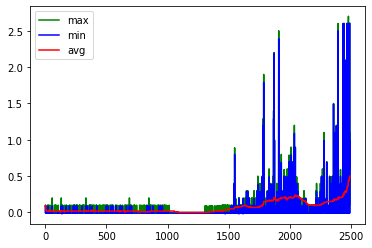

In [11]:
%matplotlib inline
result = pd.read_csv("scores.tsv", sep="\t")

ax = plt.gca()

result.plot(kind='line', y='max', color='green', ax=ax, use_index=True)
result.plot(kind='line', y='min', color='blue', ax=ax, use_index=True)
result.plot(kind='line', y='avg', color='red', ax=ax, use_index=True)

plt.show()

## Future Ideas
- Inferring policy of other agent and Ensemble methods in MADDPPG paper.
- Prioritized Experience Replay(PER)